In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import numpy as np

dec_data = np.loadtxt('/content/drive/MyDrive/Copy of Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('/content/drive/MyDrive/Copy of Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('/content/drive/MyDrive/Copy of Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('/content/drive/MyDrive/Copy of Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_data.shape)
print(dec_train.shape)
print(dec_val.shape)
print(dec_test.shape)

(149, 254750)
(149, 203800)
(149, 50950)
(149, 159822)


In [ ]:
# load packages
import pandas as pd
import pickle
import numpy as np
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.layers import LeakyReLU
# from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical
# from keras.utils import np_utils

from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# set random seeds
np.random.seed(1)
tf.random.set_seed(2)

In [ ]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T - 1:N]
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(dataX.shape + (1,)), dataY

def prepare_x_y(data, k, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    y = y[:,k] - 1
    y = to_categorical(y, 3)
    return x, y

In [ ]:
k = 4 # which prediction horizon
T = 10 # the length of a single input i. e lookback_timestep THIS HYPERPARAMETER IS FINE TUNED FOR MODEL CONVERGENCE
n_hiddens = 64
checkpoint_filepath = '/content/drive/MyDrive/BackWeight/mlp_model.weights.h5'
# checkpoint_filepath = './model_tensorflow2/weights'

In [ ]:
# Training Dataset Shrinking
# dec_train = dec_train[:,:50000]
print(dec_train.shape)
trainX_CNN, trainY_CNN = prepare_x_y(dec_train, k, T)
print(trainX_CNN.shape, trainY_CNN.shape)

(149, 203800)
(203791, 10, 40, 1) (203791, 3)


In [ ]:
# Testing Dataset Shrinking
# dec_test = dec_test[:,:20000]
print(dec_test.shape)
testX_CNN, testY_CNN = prepare_x_y(dec_test, k, T)
print(testX_CNN.shape, testY_CNN.shape)

(149, 159822)
(159813, 10, 40, 1) (159813, 3)


In [ ]:

# Validation Dataset Shrinking
# dec_val = dec_val[:,:10000]
print(dec_val.shape)
valX_CNN, valY_CNN = prepare_x_y(dec_val, k, T)
print(valX_CNN.shape, valY_CNN.shape)

(149, 50950)
(50941, 10, 40, 1) (50941, 3)


In [ ]:
print(trainX_CNN.shape, trainY_CNN.shape)
print(valX_CNN.shape, valY_CNN.shape)
print(testX_CNN.shape, testY_CNN.shape)

(203791, 10, 40, 1) (203791, 3)
(50941, 10, 40, 1) (50941, 3)
(159813, 10, 40, 1) (159813, 3)


In [ ]:
# Import necessary layers for MLP
from keras.layers import Flatten

def create_mlp(input_shape, n_classes):

    input_layer = Input(shape=(input_shape,))

    # First fully connected layer with 128 neurons
    dense1 = Dense(128, activation='relu')(input_layer)
    dense1 = Dropout(0.2)(dense1)

    # Second fully connected layer with 64 neurons
    dense2 = Dense(64, activation='relu')(dense1)
    dense2 = Dropout(0.2)(dense2)

    # Output layer for classification with softmax activation
    output_layer = Dense(n_classes, activation='softmax')(dense2)

    # Create and compile the model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model



In [ ]:
# Update the dimensions: Flatten CNN data for MLP
trainX_MLP = trainX_CNN.reshape((trainX_CNN.shape[0], -1))  # Flatten the input
valX_MLP = valX_CNN.reshape((valX_CNN.shape[0], -1))
testX_MLP = testX_CNN.reshape((testX_CNN.shape[0], -1))

# Create MLP model
mlp_model = create_mlp(trainX_MLP.shape[1], 3)  # 3 classes for classification
mlp_model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          51,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,779 (233.51 KB)

 Trainable params: 59,779 (233.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Training the MLP model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

mlp_model.fit(trainX_MLP, trainY_CNN, validation_data=(valX_MLP, valY_CNN),
              epochs=10, batch_size=128, verbose=2, callbacks=[model_checkpoint_callback])



Epoch 1/10
1593/1593 - 4s - 2ms/step - accuracy: 0.6044 - loss: 0.8490 - val_accuracy: 0.4223 - val_loss: 1.0631
Epoch 2/10
1593/1593 - 5s - 3ms/step - accuracy: 0.6091 - loss: 0.8400 - val_accuracy: 0.3931 - val_loss: 1.0850
Epoch 3/10
1593/1593 - 5s - 3ms/step - accuracy: 0.6163 - loss: 0.8304 - val_accuracy: 0.4203 - val_loss: 1.0574
Epoch 4/10
1593/1593 - 4s - 3ms/step - accuracy: 0.6208 - loss: 0.8232 - val_accuracy: 0.4484 - val_loss: 1.0460
Epoch 5/10
1593/1593 - 5s - 3ms/step - accuracy: 0.6259 - loss: 0.8151 - val_accuracy: 0.4424 - val_loss: 1.0510
Epoch 6/10
1593/1593 - 4s - 3ms/step - accuracy: 0.6295 - loss: 0.8080 - val_accuracy: 0.4511 - val_loss: 1.0387
Epoch 7/10
1593/1593 - 4s - 2ms/step - accuracy: 0.6348 - loss: 0.8006 - val_accuracy: 0.4338 - val_loss: 1.0495
Epoch 8/10
1593/1593 - 3s - 2ms/step - accuracy: 0.6365 - loss: 0.7952 - val_accuracy: 0.4451 - val_loss: 1.0341
Epoch 9/10
1593/1593 - 6s - 4ms/step - accuracy: 0.6420 - loss: 0.7900 - val_accuracy: 0.4463 - 

In [ ]:
# Load best model and predict
mlp_model.load_weights(checkpoint_filepath)
pred = mlp_model.predict(testX_MLP)

4995/4995 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


In [ ]:
# Evaluate the model
print('accuracy_score:', accuracy_score(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1)))
print(classification_report(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), digits=4))

accuracy_score: 0.5253765338239067
              precision    recall  f1-score   support

           0     0.4533    0.8261    0.5854     53063
           1     0.7684    0.2550    0.3829     57151
           2     0.5788    0.5153    0.5452     49599

    accuracy                         0.5254    159813
   macro avg     0.6002    0.5321    0.5045    159813
weighted avg     0.6050    0.5254    0.5005    159813



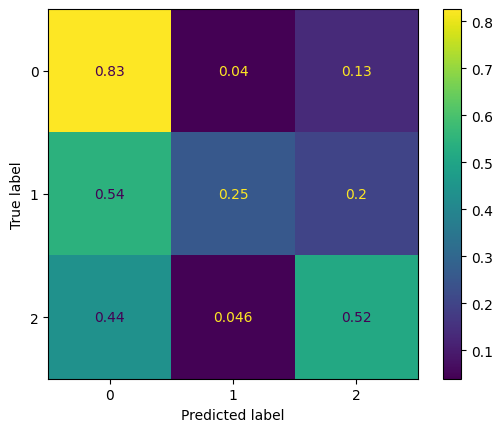

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
c = confusion_matrix(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()